In [8]:
# notebooks/01_Founder_Model_Training.ipynb (Cell 1: Data Generation)

import pandas as pd
import numpy as np
import os

# --- Configuration ---
SYNTHETIC_DATA_PATH = '../data/synthetic_founder_data.csv' # Relative path from notebook to data folder
NUM_SAMPLES = 1000
RANDOM_SEED = 42

# --- Generate Data ---
print("--- Generating Synthetic Founder Data ---")
np.random.seed(RANDOM_SEED) # for reproducibility

# Features
years_exp = np.random.uniform(0, 25, NUM_SAMPLES)
prior_exits = np.random.randint(0, 5, NUM_SAMPLES)
# Education tier: 1 (e.g., < Bachelor's), 2 (Bachelor's/Master's), 3 (PhD/Top Tier/Ivy) - simplified concept
education_tier = np.random.randint(1, 4, NUM_SAMPLES)

# Create a synthetic 'success' target variable (0=No, 1=Yes)
# Make success slightly more likely with experience, exits, and higher education tier
success_probability = (
    0.1 + # Base probability
    (years_exp / 75) +      # Experience helps moderately
    (prior_exits * 0.15) +  # Exits help significantly
    (education_tier * 0.07) # Higher tier helps a bit more
)
# Clip probabilities to be realistic (e.g., between 5% and 95%)
success_probability = np.clip(success_probability, 0.05, 0.95)
# Generate binary success outcomes based on the probability
success = (np.random.rand(NUM_SAMPLES) < success_probability).astype(int)

# Create DataFrame
df_synthetic = pd.DataFrame({
    'years_exp': years_exp,
    'prior_exits': prior_exits,
    'education_tier': education_tier,
    'success': success
})

# --- Save Data ---
# Ensure the data directory exists
data_dir = os.path.dirname(SYNTHETIC_DATA_PATH)
os.makedirs(data_dir, exist_ok=True)

df_synthetic.to_csv(SYNTHETIC_DATA_PATH, index=False)
print(f"Generated {len(df_synthetic)} samples.")
print(f"Synthetic data saved to: {SYNTHETIC_DATA_PATH}")
print("Sample data head:\n", df_synthetic.head())
print("\nSuccess distribution:\n", df_synthetic['success'].value_counts(normalize=True))
print("-" * 30)

--- Generating Synthetic Founder Data ---
Generated 1000 samples.
Synthetic data saved to: ../data/synthetic_founder_data.csv
Sample data head:
    years_exp  prior_exits  education_tier  success
0   9.363503            3               3        1
1  23.767858            2               2        1
2  18.299849            4               3        1
3  14.966462            0               2        1
4   3.900466            4               1        1

Success distribution:
 success
1    0.694
0    0.306
Name: proportion, dtype: float64
------------------------------


In [9]:
# notebooks/01_Founder_Model_Training.ipynb (Cell 2: Imports & Config)

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import joblib # For saving the scaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Make sure pandas is imported if not done in cell 1
import os           # Make sure os is imported if not done in cell 1


# --- Configuration ---
# Ensure this points correctly relative to the notebook's location
DATA_PATH = '../data/synthetic_founder_data.csv'
MODEL_SAVE_DIR = '../models'

# --- DEFINE FILENAMES ---
MODEL_FILENAME = 'founder_success_model.keras' # Explicitly use .keras extension
SCALER_FILENAME = 'founder_scaler.joblib'
# ------------------------

TEST_SIZE = 0.2
RANDOM_STATE = 42
EPOCHS = 50
BATCH_SIZE = 32

# Ensure the model output directory exists
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

# --- CONSTRUCT FULL PATHS ---
MODEL_SAVE_PATH = os.path.join(MODEL_SAVE_DIR, MODEL_FILENAME) # Path for the .keras file
SCALER_SAVE_PATH = os.path.join(MODEL_SAVE_DIR, SCALER_FILENAME)
# ----------------------------

# Add print statements to verify paths during execution
print("--- Configuration Settings ---")
print(f"Notebook execution directory: {os.getcwd()}") # Shows where notebook thinks it is
print(f"Data Path: {DATA_PATH}")
print(f"Model Save Directory: {MODEL_SAVE_DIR}")
print(f"--> Model Filename: {MODEL_FILENAME}")
print(f"--> Scaler Filename: {SCALER_FILENAME}")
print(f"Model FULL Save Path: {MODEL_SAVE_PATH}")
print(f"Scaler FULL Save Path: {SCALER_SAVE_PATH}")
print("-" * 30)

--- Configuration Settings ---
Notebook execution directory: d:\Ai agents Projects\AI Venture Capital Scout\nootbooks
Data Path: ../data/synthetic_founder_data.csv
Model Save Directory: ../models
--> Model Filename: founder_success_model.keras
--> Scaler Filename: founder_scaler.joblib
Model FULL Save Path: ../models\founder_success_model.keras
Scaler FULL Save Path: ../models\founder_scaler.joblib
------------------------------


In [10]:
# notebooks/01_Founder_Model_Training.ipynb (Cell 3: Load & Preprocess Data)

print(f"\n--- Loading Data for Training from {DATA_PATH} ---")
df = pd.read_csv(DATA_PATH)
print("Data loaded successfully.")

# Define Features (X) and Target (y)
features = ['years_exp', 'prior_exits', 'education_tier']
target = 'success'
X = df[features]
y = df[target]

print(f"\nFeatures: {features}")
print(f"Target: {target}")

# Split Data into Training and Testing sets
print(f"\n--- Splitting Data (Test Size: {TEST_SIZE}) ---")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y # Stratify helps balance classes in splits
)
print(f"Training set shape: X={X_train.shape}, y={y_train.shape}")
print(f"Test set shape: X={X_test.shape}, y={y_test.shape}")

# Scale Numerical Features (Crucial for Neural Networks)
# Fit the scaler ONLY on the training data, then transform both train and test sets
print("\n--- Scaling Features using StandardScaler ---")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to DataFrames (optional, but can be useful for inspection)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=features, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=features, index=X_test.index)

print("Sample of scaled training data:\n", X_train_scaled_df.head())


--- Loading Data for Training from ../data/synthetic_founder_data.csv ---
Data loaded successfully.

Features: ['years_exp', 'prior_exits', 'education_tier']
Target: success

--- Splitting Data (Test Size: 0.2) ---
Training set shape: X=(800, 3), y=(800,)
Test set shape: X=(200, 3), y=(200,)

--- Scaling Features using StandardScaler ---
Sample of scaled training data:
      years_exp  prior_exits  education_tier
839   0.480519    -0.727539       -1.219032
743   0.043262    -0.727539        0.001526
847   1.711208    -1.428781        1.222084
301   0.139913     0.674945       -1.219032
252   1.219292    -0.026297        1.222084


In [11]:
# notebooks/01_Founder_Model_Training.ipynb (Cell 4: Build TensorFlow Model)

print("\n--- Building TensorFlow Keras Model ---")

# Simple Sequential Model
model = tf.keras.models.Sequential([
    # Input layer: shape depends on the number of features
    tf.keras.layers.Input(shape=(X_train_scaled.shape[1],), name="Input_Layer"),
    # Hidden layers with ReLU activation
    tf.keras.layers.Dense(16, activation='relu', name="Hidden_Layer_1"),
    tf.keras.layers.Dropout(0.3), # Dropout for regularization (reduce overfitting)
    tf.keras.layers.Dense(8, activation='relu', name="Hidden_Layer_2"),
    # Output layer: 1 neuron with sigmoid activation for binary classification (outputs probability 0-1)
    tf.keras.layers.Dense(1, activation='sigmoid', name="Output_Layer")
])

# Compile the model: Specify optimizer, loss function, and metrics
model.compile(optimizer='adam', # Adam is a common and effective optimizer
              loss='binary_crossentropy', # Standard loss for binary classification
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]) # Track accuracy and Area Under Curve

# Print model summary
print(model.summary())


--- Building TensorFlow Keras Model ---


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Hidden_Layer_1 (Dense)          │ (None, 16)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_Layer_2 (Dense)          │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 209 (836.00 B)

 Trainable params: 209 (836.00 B)

 Non-trainable params: 0 (0.00 B)

None



--- Training Model for 50 Epochs ---
Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.3666 - auc: 0.4715 - loss: 0.7984 - val_accuracy: 0.4250 - val_auc: 0.4359 - val_loss: 0.7340
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4448 - auc: 0.4809 - loss: 0.7416 - val_accuracy: 0.4812 - val_auc: 0.4741 - val_loss: 0.7055
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5110 - auc: 0.4958 - loss: 0.7077 - val_accuracy: 0.6062 - val_auc: 0.5121 - val_loss: 0.6835
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5700 - auc: 0.5077 - loss: 0.6886 - val_accuracy: 0.6750 - val_auc: 0.5490 - val_loss: 0.6642
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7193 - auc: 0.6013 - loss: 0.6538 - val_accuracy: 0.6938 - val_auc: 0.5917 - val_loss: 0.6465
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6877 - auc: 0.6325 - loss: 0.6399 - val_accuracy: 0.6938 - val_auc: 0.6218 - val_loss: 0.6320
Epoch 7/50
2

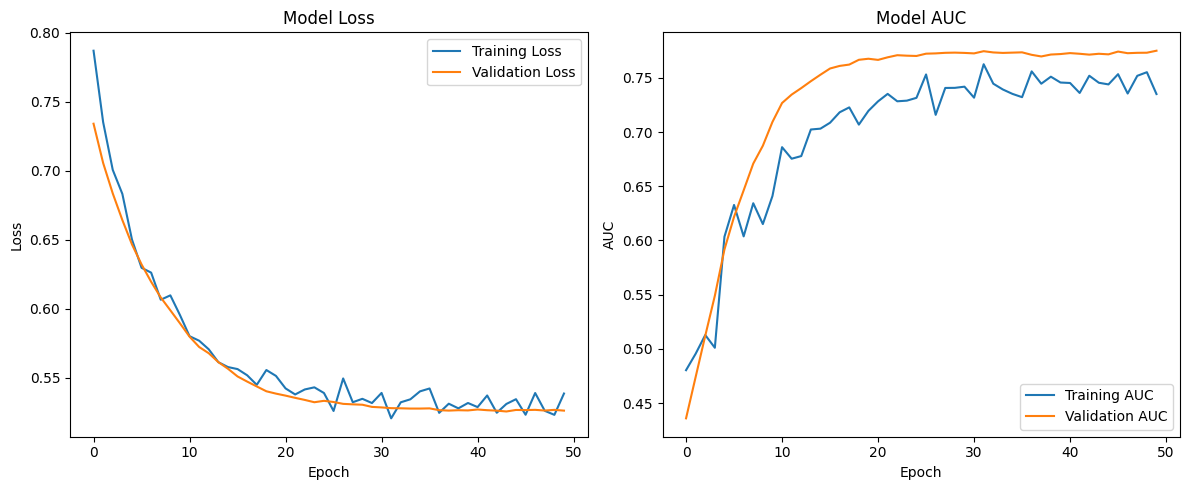

In [12]:
# notebooks/01_Founder_Model_Training.ipynb (Cell 5: Train the Model)

print(f"\n--- Training Model for {EPOCHS} Epochs ---")

# Train the model using the scaled training data
# validation_split uses a portion of the training data to monitor performance on unseen data during training
history = model.fit(
    X_train_scaled,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2, # Use 20% of training data for validation
    verbose=1 # Show progress bar (set to 0 for silent, 2 for one line per epoch)
)

print("\nModel training complete.")

# Plot training history (Loss and AUC) - Optional but helpful
print("\n--- Plotting Training History ---")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot Loss
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Model Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend()

# Plot AUC
ax2.plot(history.history['auc'], label='Training AUC')
ax2.plot(history.history['val_auc'], label='Validation AUC')
ax2.set_title('Model AUC')
ax2.set_ylabel('AUC')
ax2.set_xlabel('Epoch')
ax2.legend()

plt.tight_layout()
plt.show()


--- Evaluating Model on Test Set ---
Test Loss: 0.5250
Test Accuracy: 0.7500
Test AUC: 0.7599
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.63      0.43      0.51        61
           1       0.78      0.89      0.83       139

    accuracy                           0.75       200
   macro avg       0.71      0.66      0.67       200
weighted avg       0.74      0.75      0.73       200


Confusion Matrix (Test Set):


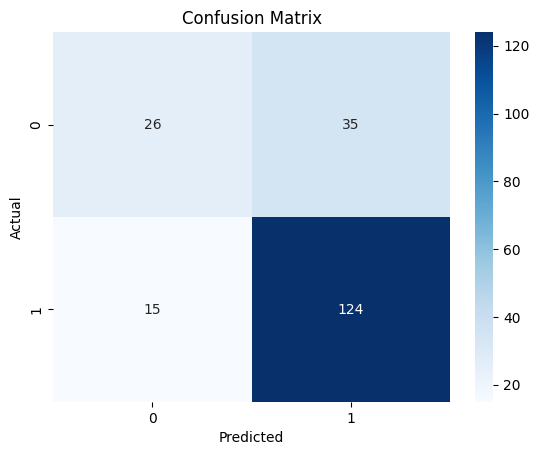

In [13]:
# notebooks/01_Founder_Model_Training.ipynb (Cell 6: Evaluate the Model)

print("\n--- Evaluating Model on Test Set ---")

# Evaluate the trained model on the unseen test data (scaled)
loss, accuracy, auc = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test AUC: {auc:.4f}")

# Generate predictions to create classification report and confusion matrix
y_pred_proba = model.predict(X_test_scaled).flatten() # Get probabilities
y_pred_binary = (y_pred_proba > 0.5).astype(int) # Convert probabilities to 0 or 1 using 0.5 threshold

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_binary))

print("\nConfusion Matrix (Test Set):")
cm = confusion_matrix(y_test, y_pred_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [14]:
# notebooks/01_Founder_Model_Training.ipynb (Cell 7: Save Model and Scaler)

print("\n--- Saving Model and Scaler ---")

# --- Save using model.save() with the .keras filepath variable ---
# This variable (MODEL_SAVE_PATH) MUST end with '.keras' based on Cell 2
model.save(MODEL_SAVE_PATH)
# ---------------------------------------------------------------
# Check if the file was actually created
model_exists = os.path.exists(MODEL_SAVE_PATH)
print(f"TensorFlow model saved to file: {MODEL_SAVE_PATH} (Exists: {model_exists})")
if not model_exists:
    print("ERROR: Model file was NOT created after model.save() call!")


# Save the scaler object using joblib (This line remains the same)
joblib.dump(scaler, SCALER_SAVE_PATH)
scaler_exists = os.path.exists(SCALER_SAVE_PATH)
print(f"Scaler object saved to: {SCALER_SAVE_PATH} (Exists: {scaler_exists})")
if not scaler_exists:
    print("ERROR: Scaler file was NOT created after joblib.dump() call!")


print("\n--- Founder Model Training Notebook Complete ---")


--- Saving Model and Scaler ---
TensorFlow model saved to file: ../models\founder_success_model.keras (Exists: True)
Scaler object saved to: ../models\founder_scaler.joblib (Exists: True)

--- Founder Model Training Notebook Complete ---
